In [7]:
import random

import numpy as np

from AdEMAMix import AdEMAMix
import cv2
import matplotlib.pyplot as plt
from NCA import *
import utils
from IPython.display import Image, HTML, clear_output

import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [8]:
#matplotlib.use("TkAgg")
DEVICE = "cuda:0"
HEIGHT = 50
WIDTH = 50
CHANNELS = 12
BATCH_SIZE = 16
MASKING = 0


In [9]:
base = cv2.imread(f"./Images/fract.png", cv2.IMREAD_UNCHANGED)
base = cv2.resize(base, (int(HEIGHT), int(WIDTH)), interpolation=cv2.INTER_AREA)
base_2 = base / 255
base_2[..., :3] *= base_2[..., 3:]
base_torch = torch.tensor(base_2, dtype=torch.float32, requires_grad=True).permute((2, 0, 1)).cuda()
base_tt = base_torch.cpu().permute((1, 2, 0)).clone().detach().numpy()

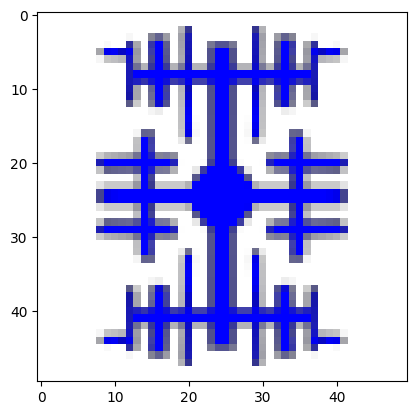

In [10]:
x_prime = torch.zeros((CHANNELS, HEIGHT, WIDTH), dtype=torch.float32).cuda()
x_prime[:, int(WIDTH / 2), int(HEIGHT / 2)] = 1.0
plt.figure(3)
plt.imshow(base_tt)

In [11]:
sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], dtype=torch.float32, device="cuda:0")
lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]], dtype=torch.float32, device="cuda:0")
filters = torch.stack([sobel_x, sobel_x.T, lap])
folders = ["Fract/Dummy"]
ncas = [DummyVCA,MaskedCA,ReducedCA]
maskings = [0]

Fract/Dummy/DummyVCA_padding_0


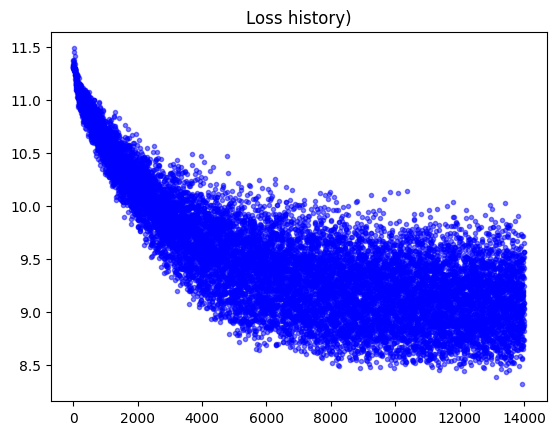

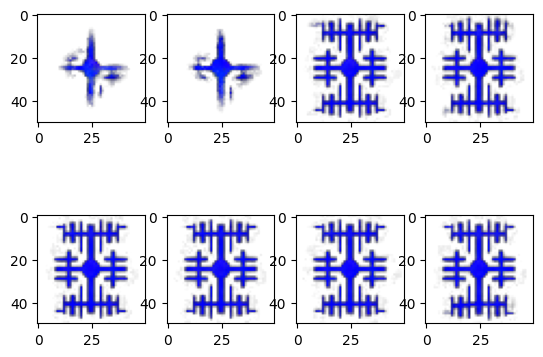

In [12]:
for ncax, folder in zip(ncas,folders):
    for masking in maskings:

        pool = torch.tile(x_prime, (8000, 1, 1, 1))
        loss_log = []
        nca = ncax(CHANNELS,96, masking)
        nca = nca.to(DEVICE)
        optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2500, gamma=0.3)
        name = folder + "/" +type(nca).__name__ + "_padding_" +str(masking)
        for i in range(14000 + 1):
            loss = 0
            with torch.no_grad():
                x, idxs = utils.get_batch(pool,x_prime,BATCH_SIZE)
            #optim.zero_grad()
            for _ in range( random.randrange(32,92)):
                x = nca(x)
            loss = (base_torch[None,...] - x[:, :4, :, :]).pow(2).sum() + 0.1 *(perchannel_conv(base_torch[None,...], filters) - perchannel_conv(x[:, :4, :, :], filters) ).pow(2).sum() 
            with torch.no_grad():
                loss.backward()
                for p in nca.parameters():
                    p.grad /= (p.grad.norm() + 1e-8)
                optim.step()
                
                x = x.detach()
                optim.zero_grad()
            
            
            loss_log.append(loss.log().item())
            pool = utils.update_pool(pool, x.clone().detach(), idxs)
            #loss.backward()
            #torch.nn.utils.clip_grad_norm_(nca.parameters(), 0.1)
            #optim.step()
            scheduler.step()
            #x = x.detach()
            #loss = loss.detach()
            if i % 100 == 0:
                print(f"Training itter {i}, loss = {loss.item()}")
                plt.clf()
                clear_output()
                plt.figure(1,figsize=(10, 4))
                plt.title('Loss history)')
                print(name)
                plt.plot(loss_log, '.', alpha=0.5, color = "b")
                utils.show_batch(x)
                plt.show(block=False)
                plt.pause(0.01)
            if i % 100 == 0:
                torch.save(nca.state_dict(), "Trained_models/" + name + ".pth")

        np_logg = np.asarray(loss_log)
        np.save("Saved_Data/" + name + "_data", np_logg)
